# US GP

## To do
- remove y0 intercept
- gridposition as fixed feature?? not for US GP (low downforce)


# Prediction Flow

In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=int(weather_df["Rainfall"].any()) # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [4]:
# We are not getting clean air race pace. We are getting the BEST pace from practice sessions. After talking to some people in the industry, I realised that
# the pace of the car in clean air might not be a very powerful predictive variable given that for most of the race the track WILL have other cars on it (shocker).

def get_best_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])
            # Note that while we are dropping DriverNumber, the 'Driver' column remaining contains abbreviations of the drivers for future mapping.

            laps = laps[(laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True].copy()
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        personalbest_map
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

After conferring with people within the domain, I realised that my method of categorising downforce (reverse ranking Hamilton's 2022 top speeds for qualifying sessions) was not very accurate, as it classified Canada as a high downforce circuit when it really is a low downforce circuit. 

To fix this problem, I decided to rely on domain knowledge and used Pirelli's classification of circuits by downforce, which you can find [here](https://f1bythenumbers.com/2019-f1-season-tracks-according-to-pirelli/).

Here is the mapping:

```python
downforce_numeric_mapping = {
    'Australia':4,
    'Bahrain':2,
    'China':2,
    'Baku':2,
    'Spain':4,
    'Monaco':5,
    'Canada':2,
    'Austria':3,
    'Silverstone':4,
    'Hungary':4,
    'Belgium':2,
    'Monza':1,
    'Singapore':5,
    'Japan':3,
    'United States':3,
    'Mexico':4,
    'Brazil':4,
    'Abu Dhabi':3,
    'Saudi Arabia': 2, // From here onwards, Pirelli does not have the classification but I've assigned values based on similar circuits
    'Miami': 2,
    'Imola':4,
    'Netherlands':4
}
```


In [5]:
# Build Model Train Data
# To be used for normalisation
from sklearn.preprocessing import StandardScaler
import logging
from sklearn.preprocessing import LabelEncoder

logging.getLogger('fastf1').setLevel(logging.ERROR) # Truncate fastf1 console logs

train_sessions={2024:['United States'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza','Baku','Singapore']}
train_df=pd.DataFrame()
y=pd.DataFrame()
le_team = LabelEncoder()
le_race = LabelEncoder()
le_year=LabelEncoder()
le_driver = LabelEncoder()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R') # Get race results for all the races in the list
        cur_session.load()
        print(f"--------------------------------------------------\nLoaded Data for {year} {race}\n--------------------------------------------------")
        cur_results=cur_session.results
        
        #-----------------DROP UNNECESSARY COLUMNS-----------------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        
        #------------------CALCULATE TOTAL RACETIME------------
        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        # Deal w Null values
        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        #-------------------------------------------------------------
        
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        
        #----------------------FEATURE ENGINEERING--------------------
        
        # Calculate average qualifying position per team and subtract the drivers' quali positions from the mean of their combined grid positions.
        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #-------------------------------------------------------------
        
        
        #----------------------GET BEST RACE PACE----------------------
        # Get best track race pace across FP1, FP2 and FP3
        best_race_pace=get_best_race_pace(year,race)
        # print("Got Best Race Pace") # Debug
        best_race_pace
        
        best_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=best_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['Best_Pace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------------------------
        
        
        #--------------------MORE FEATURE ENGINEERING------------------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['Best_Pace_seconds'] - cur_results['Best_Pace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['Best_Pace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #--------------------------------------------------------------

        #------------------GET RACE DAY WEATHER DATA--------------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #---------------------------------------------------------------
        
        #---------------------------IS IT SINGAPORE?-------------------------
        if race!='United States':
            cur_results['Is_US']=0
        else:
            cur_results['Is_US']=1
        #---------------------------------------------------------------
        
        #-----------------------MAP DOWNFORCE LEVELS & SAFETY CAR PROBABILITIES---------------------
    
        downforce_map = {
            'Australia':4,
            'Bahrain':2,
            'China':2,
            'Baku':2,
            'Spain':4,
            'Monaco':5,
            'Canada':2,
            'Austria':3,
            'Silverstone':4,
            'Hungary':4,
            'Belgium':2,
            'Monza':1,
            'Singapore':5,
            'Japan':3,
            'United States':3,
            'Mexico':4,
            'Brazil':4,
            'Abu Dhabi':3,
            'Saudi Arabia': 2, 
            'Miami': 2,
            'Imola':4,
            'Netherlands':4
        }
        cur_results['Downforce_Level'] = cur_results['Race'].map(downforce_map)
        
        #-----------------------------------------------------------------
   
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
# Encode categoricals
train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
train_df['Year_encoded'] = le_year.fit_transform(train_df['Year'])
train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

#-----------------------ADD INTERACTION TERMS---------------------
# Grid position matters MORE on high-downforce tracks (harder to overtake)
train_df['GridPos_x_Downforce'] = train_df['GridPosition'] * train_df['Downforce_Level']

# Fast practice pace + good grid position = compound advantage
train_df['Pace_x_GridPos'] = train_df['Best_Pace_seconds'] * train_df['GridPosition']

# Team performance varies by track type
train_df['Team_x_Downforce'] = train_df['TeamId_encoded'] * train_df['Downforce_Level']
 

--------------------------------------------------
Loaded Data for 2024 United States
--------------------------------------------------
Skipping FP2 for 2024 United States: Session type 'FP2' does not exist for this event
Skipping FP3 for 2024 United States: Session type 'FP3' does not exist for this event
--------------------------------------------------
Loaded Data for 2025 Australia
--------------------------------------------------
--------------------------------------------------
Loaded Data for 2025 China
--------------------------------------------------
Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
--------------------------------------------------
Loaded Data for 2025 Japan
--------------------------------------------------
--------------------------------------------------
Loaded Data for 2025 Bahrain
--------------------------------------------------
-------------

In [6]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Quali_vs_Teammate,Race,Year,...,TrackTemp,Is_US,Downforce_Level,TeamId_encoded,Race_encoded,Year_encoded,Driver_encoded,GridPos_x_Downforce,Pace_x_GridPos,Team_x_Downforce
0,LEC,ferrari,4.0,0 days 01:35:09.639000,56.0,5709.639,99.804962,0.5,United States,2024,...,46.601935,1,3,2,18,0,13,12.0,374.492,6
1,SAI,ferrari,3.0,0 days 00:00:08.562000,56.0,5718.201,99.954868,-0.5,United States,2024,...,46.601935,1,3,2,18,0,20,9.0,280.806,6
2,VER,red_bull,2.0,0 days 00:00:19.412000,56.0,5729.051,100.156132,-3.5,United States,2024,...,46.601935,1,3,7,18,0,23,6.0,187.710,21
3,NOR,mclaren,1.0,0 days 00:00:20.354000,56.0,5729.993,100.106642,-2.0,United States,2024,...,46.601935,1,3,4,18,0,15,3.0,93.868,12
4,PIA,mclaren,5.0,0 days 00:00:21.921000,56.0,5731.560,101.173500,2.0,United States,2024,...,46.601935,1,3,4,18,0,18,15.0,469.540,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,COL,alpine,16.0,0 days 00:00:42.890000,61.0,6065.257,99.213833,-1.5,Singapore,2025,...,33.852174,0,5,0,16,1,6,80.0,1456.752,0
375,BOR,sauber,14.0,0 days 00:00:46.753000,61.0,6069.120,99.251050,1.5,Singapore,2025,...,33.852174,0,5,8,16,1,4,70.0,1269.758,40
376,OCO,haas,17.0,0 days 00:00:47.133000,61.0,6069.500,99.233950,4.0,Singapore,2025,...,33.852174,0,5,3,16,1,16,85.0,1543.328,15
377,GAS,alpine,19.0,0 days 00:00:47.461000,61.0,6069.828,99.224783,1.5,Singapore,2025,...,33.852174,0,5,0,16,1,8,95.0,1741.217,0


In [7]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Quali_vs_Teammate', 'Race', 'Year',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded', 'Driver_encoded', 'GridPos_x_Downforce',
       'Pace_x_GridPos', 'Team_x_Downforce'],
      dtype='object')

In [8]:
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# import matplotlib.pyplot as plt

# # train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])
# columns=['GridPosition', 'Time (s)',
#        'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
#        'Year', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
#        'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
#        'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level','TeamId','Driver']

# sampled_df=train_df[columns]

# # Encode categoricals
# le_team = LabelEncoder()
# le_race = LabelEncoder()
# le_year=LabelEncoder()
# le_driver = LabelEncoder()

# sampled_df['TeamId_encoded'] = le_team.fit_transform(sampled_df['TeamId'])
# sampled_df['Race_encoded'] = le_race.fit_transform(sampled_df['Race'])
# sampled_df['Year_encoded'] = le_year.fit_transform(sampled_df['Year'])
# sampled_df['Driver_encoded'] = le_driver.fit_transform(sampled_df['Driver'])
# sampled_df.drop(columns=['Race','Year','Driver','TeamId'],inplace=True)

# corr = sampled_df.corr()

# plt.figure(figsize=(10, 8))
# plt.matshow(corr, fignum=1, cmap='coolwarm')

# # Add labels
# plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
# plt.yticks(range(len(corr.columns)), corr.columns)

# plt.colorbar()
# plt.title("Correlation Matrix", pad=20)
# plt.tight_layout()
# plt.show()

In [9]:
# train_df.drop(columns=['Grid_Gap_to_Pole'])

In [10]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Quali_vs_Teammate', 'Race', 'Year',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded', 'Driver_encoded', 'GridPos_x_Downforce',
       'Pace_x_GridPos', 'Team_x_Downforce'],
      dtype='object')

In [11]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,...,TrackTemp,Is_US,Downforce_Level,TeamId_encoded,Race_encoded,Year_encoded,Driver_encoded,GridPos_x_Downforce,Pace_x_GridPos,Team_x_Downforce
0,LEC,ferrari,4.0,99.804962,0.5,United States,2024,93.623,0.021,-2.0,...,46.601935,1,3,2,18,0,13,12.0,374.492,6
1,SAI,ferrari,3.0,99.954868,-0.5,United States,2024,93.602,0.000,-2.0,...,46.601935,1,3,2,18,0,20,9.0,280.806,6
2,VER,red_bull,2.0,100.156132,-3.5,United States,2024,93.855,0.253,1.0,...,46.601935,1,3,7,18,0,23,6.0,187.710,21
3,NOR,mclaren,1.0,100.106642,-2.0,United States,2024,93.868,0.266,3.0,...,46.601935,1,3,4,18,0,15,3.0,93.868,12
4,PIA,mclaren,5.0,101.173500,2.0,United States,2024,93.908,0.306,0.0,...,46.601935,1,3,4,18,0,18,15.0,469.540,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,COL,alpine,16.0,99.213833,-1.5,Singapore,2025,91.047,0.899,0.0,...,33.852174,0,5,0,16,1,6,80.0,1456.752,0
375,BOR,sauber,14.0,99.251050,1.5,Singapore,2025,90.697,0.549,-2.0,...,33.852174,0,5,8,16,1,4,70.0,1269.758,40
376,OCO,haas,17.0,99.233950,4.0,Singapore,2025,90.784,0.636,-4.0,...,33.852174,0,5,3,16,1,16,85.0,1543.328,15
377,GAS,alpine,19.0,99.224783,1.5,Singapore,2025,91.643,1.495,0.0,...,33.852174,0,5,0,16,1,8,95.0,1741.217,0


In [12]:
# train_df.drop(columns=['Humidity'],inplace=True)
# train_df

In [13]:
train_df.to_csv('../data/train_df_usa.csv')

In [14]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
Best_Pace_seconds          float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Humidity                   float64
Pressure                   float64
Rain                         int64
WindSpeed                  float64
TrackTemp                  float64
Is_US                        int64
Downforce_Level              int64
TeamId_encoded               int64
Race_encoded                 int64
Year_encoded                 int64
Driver_encoded               int64
GridPos_x_Downforce        float64
Pace_x_GridPos             float64
Team_x_Downforce             int64
dtype: object

In [15]:
y


,LapTime (s)
LEC,99.804962
SAI,99.954868
VER,100.156132
NOR,100.106642
PIA,101.173500
...,...
COL,99.213833
BOR,99.251050
OCO,99.233950
GAS,99.224783


In [16]:
train_df[['Race','Race_encoded']]

,Race,Race_encoded
0,United States,18
1,United States,18
2,United States,18
3,United States,18
4,United States,18
...,...,...
374,Singapore,16
375,Singapore,16
376,Singapore,16
377,Singapore,16


TRACK-SPECIFIC MODEL TRAINING (Two Groups)

Total data: 365 samples

Low-Medium DF (1-3): 211 samples
High DF (4-5):       154 samples

GROUP 1: LOW-MEDIUM DOWNFORCE TRACKS (DF 1-3)

Train: 168 samples, Test: 43 samples
Best Ridge alpha: 0.1

--- Linear Regression ---
Train MAE: 0.625s
Test MAE:  0.510s
Test R²:   0.997

--- Ridge Regression ---
Train MAE: 0.807s
Test MAE:  0.756s
Test R²:   0.994

--- 5-Fold Cross Validation ---
Linear - CV MAE: 0.603 ± 0.148
Linear - CV R²:  0.986 ± 0.017
Ridge  - CV MAE: 0.799 ± 0.140
Ridge  - CV R²:  0.984 ± 0.017

GROUP 2: HIGH DOWNFORCE TRACKS (DF 4-5)

Train: 123 samples, Test: 31 samples
Best Ridge alpha: 0.1

--- Linear Regression ---
Train MAE: 1.125s
Test MAE:  1.961s
Test R²:   0.842

--- Ridge Regression ---
Train MAE: 1.119s
Test MAE:  1.959s
Test R²:   0.842

--- 5-Fold Cross Validation ---
Linear - CV MAE: 1.637 ± 0.341
Linear - CV R²:  0.921 ± 0.050
Ridge  - CV MAE: 1.625 ± 0.349
Ridge  - CV R²:  0.922 ± 0.050

SUMMARY: Track-Specific 

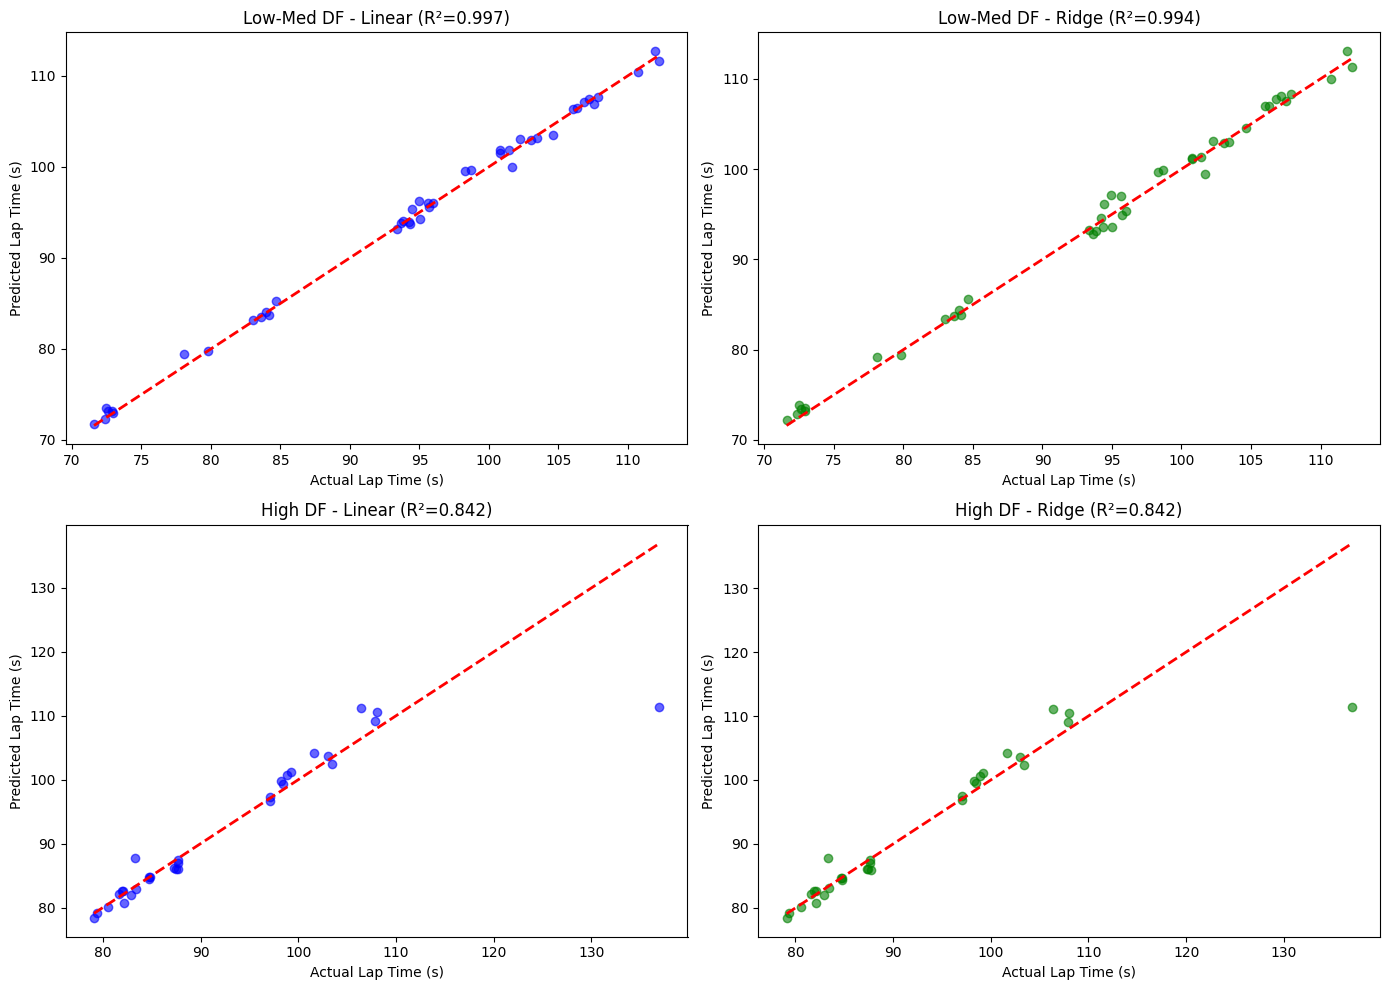


Track-specific training complete! Use appropriate model based on race DF level.


In [17]:
# TRACK-SPECIFIC MODEL TRAINING
# Two groups: Low-Medium DF (1-3) and High DF (4-5)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("TRACK-SPECIFIC MODEL TRAINING (Two Groups)")
print("="*80)

# Prepare data
drivers = train_df['Driver'].copy()
X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)', 'Year'])
X_init = X_init.fillna(0)

# Reset indices
X_reset = X_init.reset_index(drop=True)
y_reset = y.reset_index(drop=True)
drivers_reset = drivers.reset_index(drop=True)

# Remove NaN values
valid_indices = y_reset.notna().squeeze()
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]
drivers_clean = drivers_reset[valid_indices]

print(f"\nTotal data: {len(X_clean)} samples")

# Define track groups based on Downforce Level
low_med_df_mask = X_clean['Downforce_Level'] <= 3
high_df_mask = X_clean['Downforce_Level'] >= 4

# Split data by track group
X_low_med = X_clean[low_med_df_mask].copy()
y_low_med = y_clean[low_med_df_mask].copy()
drivers_low_med = drivers_clean[low_med_df_mask].copy()

X_high = X_clean[high_df_mask].copy()
y_high = y_clean[high_df_mask].copy()
drivers_high = drivers_clean[high_df_mask].copy()

print(f"\nLow-Medium DF (1-3): {len(X_low_med)} samples")
print(f"High DF (4-5):       {len(X_high)} samples")

# Define categorical columns (won't be normalized)
categorical_columns = ['Year_encoded', 'Is_US', 'Downforce_Level', 'TeamId_encoded',
                      'Race_encoded', 'Rain', 'Driver_encoded']

# Store models
models = {}

# ============================================================================
# GROUP 1: LOW-MEDIUM DOWNFORCE (1-3)
# ============================================================================
print("\n" + "="*80)
print("GROUP 1: LOW-MEDIUM DOWNFORCE TRACKS (DF 1-3)")
print("="*80)

# Identify continuous columns
continuous_columns = [col for col in X_low_med.columns if col not in categorical_columns]

# Normalize
scaler_low_med = StandardScaler().fit(X_low_med[continuous_columns])
X_low_med_norm = X_low_med.copy()
X_low_med_norm[continuous_columns] = scaler_low_med.transform(X_low_med[continuous_columns])

# Train-test split
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(
    X_low_med_norm, y_low_med, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_lm)} samples, Test: {len(X_test_lm)} samples")

# Train Linear Regression
lr_model_lm = LinearRegression()
lr_model_lm.fit(X_train_lm, y_train_lm)

# Train Ridge with GridSearchCV
param_grid = {'alpha': [0.1, 1, 5, 10, 20, 50, 100]}
ridge_grid_lm = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_lm.fit(X_train_lm, y_train_lm)
ridge_model_lm = ridge_grid_lm.best_estimator_

print(f"Best Ridge alpha: {ridge_grid_lm.best_params_['alpha']}")

# Predictions
lr_train_pred_lm = lr_model_lm.predict(X_train_lm)
lr_test_pred_lm = lr_model_lm.predict(X_test_lm)
ridge_train_pred_lm = ridge_model_lm.predict(X_train_lm)
ridge_test_pred_lm = ridge_model_lm.predict(X_test_lm)

# Evaluation
print("\n--- Linear Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_lm, lr_train_pred_lm):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_lm, lr_test_pred_lm):.3f}s")
print(f"Test R²:   {r2_score(y_test_lm, lr_test_pred_lm):.3f}")

print("\n--- Ridge Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_lm, ridge_train_pred_lm):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_lm, ridge_test_pred_lm):.3f}s")
print(f"Test R²:   {r2_score(y_test_lm, ridge_test_pred_lm):.3f}")

# 5-Fold Cross Validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error', 'r2']

lr_cv_lm = cross_validate(lr_model_lm, X_low_med_norm, y_low_med.squeeze(),
                          cv=cv_folds, scoring=scoring)
ridge_cv_lm = cross_validate(ridge_model_lm, X_low_med_norm, y_low_med.squeeze(),
                             cv=cv_folds, scoring=scoring)

print("\n--- 5-Fold Cross Validation ---")
print(f"Linear - CV MAE: {-lr_cv_lm['test_neg_mean_absolute_error'].mean():.3f} ± {lr_cv_lm['test_neg_mean_absolute_error'].std():.3f}")
print(f"Linear - CV R²:  {lr_cv_lm['test_r2'].mean():.3f} ± {lr_cv_lm['test_r2'].std():.3f}")
print(f"Ridge  - CV MAE: {-ridge_cv_lm['test_neg_mean_absolute_error'].mean():.3f} ± {ridge_cv_lm['test_neg_mean_absolute_error'].std():.3f}")
print(f"Ridge  - CV R²:  {ridge_cv_lm['test_r2'].mean():.3f} ± {ridge_cv_lm['test_r2'].std():.3f}")

# Store models
models['low_med_df'] = {
    'linear': lr_model_lm,
    'ridge': ridge_model_lm,
    'scaler': scaler_low_med,
    'downforce_range': (1, 3)
}

# ============================================================================
# GROUP 2: HIGH DOWNFORCE (4-5)
# ============================================================================
print("\n" + "="*80)
print("GROUP 2: HIGH DOWNFORCE TRACKS (DF 4-5)")
print("="*80)

# Normalize
scaler_high = StandardScaler().fit(X_high[continuous_columns])
X_high_norm = X_high.copy()
X_high_norm[continuous_columns] = scaler_high.transform(X_high[continuous_columns])

# Train-test split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_high_norm, y_high, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_h)} samples, Test: {len(X_test_h)} samples")

# Train Linear Regression
lr_model_h = LinearRegression()
lr_model_h.fit(X_train_h, y_train_h)

# Train Ridge with GridSearchCV
ridge_grid_h = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_h.fit(X_train_h, y_train_h)
ridge_model_h = ridge_grid_h.best_estimator_

print(f"Best Ridge alpha: {ridge_grid_h.best_params_['alpha']}")

# Predictions
lr_train_pred_h = lr_model_h.predict(X_train_h)
lr_test_pred_h = lr_model_h.predict(X_test_h)
ridge_train_pred_h = ridge_model_h.predict(X_train_h)
ridge_test_pred_h = ridge_model_h.predict(X_test_h)

# Evaluation
print("\n--- Linear Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_h, lr_train_pred_h):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_h, lr_test_pred_h):.3f}s")
print(f"Test R²:   {r2_score(y_test_h, lr_test_pred_h):.3f}")

print("\n--- Ridge Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_h, ridge_train_pred_h):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_h, ridge_test_pred_h):.3f}s")
print(f"Test R²:   {r2_score(y_test_h, ridge_test_pred_h):.3f}")

# 5-Fold Cross Validation
lr_cv_h = cross_validate(lr_model_h, X_high_norm, y_high.squeeze(),
                         cv=cv_folds, scoring=scoring)
ridge_cv_h = cross_validate(ridge_model_h, X_high_norm, y_high.squeeze(),
                            cv=cv_folds, scoring=scoring)

print("\n--- 5-Fold Cross Validation ---")
print(f"Linear - CV MAE: {-lr_cv_h['test_neg_mean_absolute_error'].mean():.3f} ± {lr_cv_h['test_neg_mean_absolute_error'].std():.3f}")
print(f"Linear - CV R²:  {lr_cv_h['test_r2'].mean():.3f} ± {lr_cv_h['test_r2'].std():.3f}")
print(f"Ridge  - CV MAE: {-ridge_cv_h['test_neg_mean_absolute_error'].mean():.3f} ± {ridge_cv_h['test_neg_mean_absolute_error'].std():.3f}")
print(f"Ridge  - CV R²:  {ridge_cv_h['test_r2'].mean():.3f} ± {ridge_cv_h['test_r2'].std():.3f}")

# Store models
models['high_df'] = {
    'linear': lr_model_h,
    'ridge': ridge_model_h,
    'scaler': scaler_high,
    'downforce_range': (4, 5)
}

# ============================================================================
# SUMMARY COMPARISON
# ============================================================================
print("\n" + "="*80)
print("SUMMARY: Track-Specific vs Single Model Performance")
print("="*80)

print("\n┌─────────────────────────┬──────────────┬──────────────┬──────────────┐")
print("│ Track Group             │ Test R² (LR) │ Test R² (R)  │ CV R² (R)    │")
print("├─────────────────────────┼──────────────┼──────────────┼──────────────┤")
print(f"│ Low-Med DF (1-3)        │    {r2_score(y_test_lm, lr_test_pred_lm):.3f}     │    {r2_score(y_test_lm, ridge_test_pred_lm):.3f}     │    {ridge_cv_lm['test_r2'].mean():.3f}     │")
print(f"│ High DF (4-5)           │    {r2_score(y_test_h, lr_test_pred_h):.3f}     │    {r2_score(y_test_h, ridge_test_pred_h):.3f}     │    {ridge_cv_h['test_r2'].mean():.3f}     │")
print("└─────────────────────────┴──────────────┴──────────────┴──────────────┘")

print("\n💡 Models saved in 'models' dictionary:")
print("   - models['low_med_df']['ridge'] → for tracks with DF 1-3")
print("   - models['high_df']['ridge'] → for tracks with DF 4-5")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Low-Med DF - Linear
axes[0, 0].scatter(y_test_lm, lr_test_pred_lm, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_lm.min(), y_test_lm.max()], [y_test_lm.min(), y_test_lm.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Lap Time (s)')
axes[0, 0].set_ylabel('Predicted Lap Time (s)')
axes[0, 0].set_title(f'Low-Med DF - Linear (R²={r2_score(y_test_lm, lr_test_pred_lm):.3f})')

# Low-Med DF - Ridge
axes[0, 1].scatter(y_test_lm, ridge_test_pred_lm, alpha=0.6, color='green')
axes[0, 1].plot([y_test_lm.min(), y_test_lm.max()], [y_test_lm.min(), y_test_lm.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Lap Time (s)')
axes[0, 1].set_ylabel('Predicted Lap Time (s)')
axes[0, 1].set_title(f'Low-Med DF - Ridge (R²={r2_score(y_test_lm, ridge_test_pred_lm):.3f})')

# High DF - Linear
axes[1, 0].scatter(y_test_h, lr_test_pred_h, alpha=0.6, color='blue')
axes[1, 0].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Lap Time (s)')
axes[1, 0].set_ylabel('Predicted Lap Time (s)')
axes[1, 0].set_title(f'High DF - Linear (R²={r2_score(y_test_h, lr_test_pred_h):.3f})')

# High DF - Ridge
axes[1, 1].scatter(y_test_h, ridge_test_pred_h, alpha=0.6, color='green')
axes[1, 1].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Lap Time (s)')
axes[1, 1].set_ylabel('Predicted Lap Time (s)')
axes[1, 1].set_title(f'High DF - Ridge (R²={r2_score(y_test_h, ridge_test_pred_h):.3f})')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Track-specific training complete! Use appropriate model based on race DF level.")
print("="*80)


In [18]:
X

NameError: name 'X' is not defined

In [ ]:
X.columns

Index(['GridPosition', 'Quali_vs_Teammate', 'Best_Pace_seconds',
       'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp',
       'Humidity', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_US',
       'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Year_encoded',
       'Driver_encoded', 'GridPos_x_Downforce', 'Pace_x_GridPos',
       'Team_x_Downforce'],
      dtype='object')

In [ ]:

#----------------CREATE PREDICTION DATASET-----------------

predict_df = pd.DataFrame()
predict_df['Abbreviation'] = ['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)

flex_map = {
    'PIA': 2.0, 
    'NOR': 3.0, 
    'VER': 0.0, 
    'TSU': 0.8, 
    'HAD': 1.0, 
    'LAW': 0.0, 
    'ALO': 2.2, 
    'STR': -1.6, 
    'OCO': -2.2, 
    'BEA': -1.6, 
    'RUS': -1.2, 
    'ANT': 0.0, 
    'GAS': -0.2, 
    'COL': 1.2, 
    'HAM': -1.2, 
    'LEC': 3.2, 
    'ALB': -5.2, 
    'SAI': 1.0, 
    'BOR': -0.2, 
    'HUL': -0.6
}
predict_df['Position_Flexibility'] = predict_df['Abbreviation'].map(flex_map)

grid_positions = {
    'RUS': 1.0,
    'VER': 2.0, 
    'PIA': 3.0,
    'ANT': 4.0,
    'NOR': 5.0,
    'HAM': 6.0,       
    'LEC': 7.0,          
    'HAD': 8.0,
    'BEA': 9.0,    
    'ALO': 10.0,
    'HUL': 11.0,            
    'ALB': 12.0,
    'SAI': 13.0,
    'LAW': 14.0,          
    'TSU': 15.0,
    'BOR': 16.0,       
    'STR': 17.0,
    'COL': 18.0,
    'OCO': 19.0,  
    'GAS': 20.0
}

predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Singapore'
predict_df['Year'] = 2025

safety_car_map={
            'Monaco': 43,
            'Canada': 83,
            'Silverstone': 88,
            'Imola': 75,
            'Hungary': 25,
            'Australia': 50,
            'Bahrain': 63,
            'Austria': 38,
            'Netherlands': 50,
            'Spain': 38,
            'Japan': 67,
            'Saudi Arabia': 100,
            'Baku': 57,
            'Belgium': 63,
            'Miami': 67,
            'Monza': 50,
            'Singapore': 83,
            'China': 75
        }
predict_df['Safety_Car_Prob'] = predict_df['Race'].map(safety_car_map)
        
virtual_safety_car_map={
    'Monaco': 29,
    'Canada': 50,
    'Silverstone': 13,
    'Imola': 25,
    'Hungary': 25,
    'Australia': 67,
    'Bahrain': 50,
    'Austria': 50,
    'Netherlands': 50,
    'Spain': 25,
    'Japan': 50,
    'Saudi Arabia': 50,
    'Baku': 43,
    'Belgium': 0,
    'Miami': 67,
    'Monza': 38,
    'Singapore': 33,
    'China': 75
}
predict_df['VSC_Prob'] = predict_df['Race'].map(virtual_safety_car_map)

# Encode categorical variables using the same encoders from training
predict_df['Race_encoded'] = le_race.transform(predict_df['Race'])
predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])
predict_df['Year_encoded'] = le_year.transform(predict_df['Year'])
# predict_df['Driver_encoded'] = le_driver.transform(predict_df['Abbreviation'])

predict_df['Is_Singapore'] = 1

# Add Downforce Level (Singapore is high downforce = 5)
predict_df['Downforce_Level'] = 5

# Add interaction terms (same as training)
predict_df['GridPos_x_Downforce'] = predict_df['GridPosition'] * predict_df['Downforce_Level']
predict_df['Pace_x_GridPos'] = predict_df['Best_Pace_seconds'] * predict_df['GridPosition']
predict_df['Team_x_Downforce'] = predict_df['TeamId_encoded'] * predict_df['Downforce_Level']


# Get practice pace data
best_race_pace = get_best_race_pace(2025, 'Singapore')
best_race_pace.drop(columns=['IsPersonalBest','Session'], inplace=True)
pace_mapping = best_race_pace.set_index('Driver')['LapTime (s)']
predict_df['Best_Pace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['Best_Pace_seconds'] - predict_df['Best_Pace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['Best_Pace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

# Weather data (predicted for race day)
predict_df['Rain'] = 0
predict_df['AirTemp'] = 30.000000
predict_df['TrackTemp'] = 33.000000
predict_df['Pressure'] = 1013.000000
predict_df['WindSpeed'] = 8.000000


# Drop original categorical columns (keep only encoded versions)
predict_df.drop(columns=['TeamId', 'Race','Year'], inplace=True)

# Rename Driver column to match training data
predict_df.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

# Create final prediction features (same structure as training)
X_predict = predict_df.drop(columns=['Driver'])
X_predict = X_predict.fillna(0)

# CRITICAL FIX: Reorder columns to match EXACTLY what the training data had
# Get the exact column order from the training data
training_columns = X_clean.columns.tolist()
print("Training columns order:", training_columns)

# Reorder prediction data to match training data exactly
X_predict = X_predict[training_columns]

print("Prediction columns order:", X_predict.columns.tolist())
print("Columns match:", list(X_predict.columns) == training_columns)

# Apply the same normalization as training data
categorical_columns = ['Year_encoded', 'Is_Singapore', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Rain']
continuous_columns = [col for col in X_predict.columns if col not in categorical_columns]

print("Continuous columns for normalization:", continuous_columns)

# Normalize only continuous columns using the same scaler fitted on training data
X_predict_normalized = X_predict.copy()
X_predict_normalized[continuous_columns] = norm.transform(X_predict[continuous_columns])

print("Prediction dataset shape:", X_predict_normalized.shape)
print("Training dataset shape:", X.shape)

KeyError: 'Best_Pace_seconds'

In [ ]:
X_predict_normalized

In [ ]:
#Make Predictions - Using Track-Specific Model

# Determine which model to use based on downforce level
# Singapore has DF=5, so use high DF model
track_downforce = 5  # Update this for different tracks

if track_downforce <= 3:
    selected_model = models['low_med_df']['ridge']
    selected_scaler = models['low_med_df']['scaler']
    model_group = "Low-Medium DF (1-3)"
else:
    selected_model = models['high_df']['ridge']
    selected_scaler = models['high_df']['scaler']
    model_group = "High DF (4-5)"

print(f"Using {model_group} model for this prediction")
print(f"Track downforce level: {track_downforce}")

# Define categorical columns (same as training)
categorical_columns = ['Year_encoded', 'Is_US', 'Downforce_Level', 'TeamId_encoded',
                      'Race_encoded', 'Rain', 'Driver_encoded']
continuous_columns = [col for col in X_predict.columns if col not in categorical_columns]

# Normalize using the appropriate scaler
X_predict_normalized = X_predict.copy()
X_predict_normalized[continuous_columns] = selected_scaler.transform(X_predict[continuous_columns])

print(f"Prediction dataset shape: {X_predict_normalized.shape}")

# Make predictions
predicted_lap_times = selected_model.predict(X_predict_normalized)

print("\n" + "="*80)
print("PREDICTIONS")
print("="*80)

results_df = pd.DataFrame({
    'Driver': predict_df['Driver'],
    'Predicted_LapTime': predicted_lap_times.flatten()
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 SINGAPORE PODIUM")
print("="*50)
print(f"Driver \t\t Average Lap Time (s)")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} \t {results_df.iloc[0]['Predicted_LapTime']:.3f}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} \t {results_df.iloc[1]['Predicted_LapTime']:.3f}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} \t {results_df.iloc[2]['Predicted_LapTime']:.3f}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df)


## Extra Analysis

In [ ]:
#Note that coefs still do NOT indicate the importance of a feature.

coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_.flatten(),
    'Abs_Coefficient': abs(lr_model.coef_.flatten())
}).sort_values('Abs_Coefficient', ascending=False)

print(coefs.head(20))

In [ ]:
# Check practice pace data for all drivers
print("=== PRACTICE PACE ANALYSIS ===")
practice_check = predict_df[['Driver', 'GridPosition']].copy()
practice_check['Best_Pace_seconds'] = X_predict['Best_Pace_seconds']
practice_check = practice_check.sort_values('Best_Pace_seconds')
print(practice_check)
print(f"\nRussell's practice pace: {practice_check[practice_check['Driver']=='RUS']['Best_Pace_seconds'].values[0]:.3f}s")
print(f"Fastest practice pace: {practice_check['Best_Pace_seconds'].min():.3f}s")
print(f"Practice pace range: {practice_check['Best_Pace_seconds'].min():.3f}s - {practice_check['Best_Pace_seconds'].max():.3f}s")